In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates
from yahooquery import Ticker
import math
import keras

In [3]:
ASSET = 'AAPL'
stck_data = Ticker(ASSET).history(interval='1d', period='max')
stck_data

open        high         low  \
symbol date                                                            
AAPL   1980-12-12                   0.128348    0.128906    0.128348   
       1980-12-15                   0.122210    0.122210    0.121652   
       1980-12-16                   0.113281    0.113281    0.112723   
       1980-12-17                   0.115513    0.116071    0.115513   
       1980-12-18                   0.118862    0.119420    0.118862   
...                                      ...         ...         ...   
       2023-10-12                 180.070007  182.339996  179.039993   
       2023-10-13                 181.419998  181.929993  178.139999   
       2023-10-16                 176.750000  179.080002  176.509995   
       2023-10-17                 176.649994  178.419998  174.800003   
       2023-10-18 16:00:01-04:00  175.580002  177.570007  175.110001   

                                       close     volume    adjclose  \
symbol date                                                           
AAPL   1980-12-12                   0.128348  469033600    0.099450   
       1980-12-15                   0.121652  175884800    0.094261   
       1980-12-16                   0.112723  105728000    0.087343   
       1980-12-17                   0.115513   86441600    0.089504   
       1980-12-18                   0.118862   73449600    0.092099   
...                                      ...        ...         ...   
       2023-10-12                 180.710007   56743100  180.710007   
       2023-10-13                 178.850006   51427100  178.850006   
       2023-10-16                 178.720001   52517000  178.720001   
       2023-10-17                 177.149994   57549400  177.149994   
       2023-10-18 16:00:01-04:00  175.839996   51894803  175.839996   

                                  dividends  splits  
symbol date                                          
AAPL   1980-12-12                       0.0     0.0  
       1980-12-15                       0.0     0.0  
       1980-12-16                       0.0     0.0  
       1980-12-17                       0.0     0.0  
       1980-12-18                       0.0     0.0  
...                                     ...     ...  
       2023-10-12                       0.0     0.0  
       2023-10-13                       0.0     0.0  
       2023-10-16                       0.0     0.0  
       2023-10-17                       0.0     0.0  
       2023-10-18 16:00:01-04:00        0.0     0.0  

[10803 rows x 8 columns]

In [4]:
train_portion = math.floor(len(stck_data['close']) * 0.8)
test_portion = math.floor(len(stck_data['close']) * 0.2)

In [5]:
training_data = stck_data['close'][:train_portion]
testing_data = stck_data['close'][test_portion:]

In [6]:
training_set = training_data.values.reshape(-1, 1)
testing_set = testing_data.values.reshape(-1, 1)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)
testing_set_scaled = scaler.fit_transform(testing_set)

In [8]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(testing_set_scaled)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [10]:
model = keras.Sequential()

Metal device set to: Apple M1


2023-10-18 22:57:10.375272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-18 22:57:10.375421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [12]:
model.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")

In [13]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100


2023-10-18 22:57:17.652244: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-18 22:57:20.122690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 22:57:20.472586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x60x1x50xi1>'
2023-10-18 22:57:21.674910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

267/269 [============================>.] - ETA: 0s - loss: 0.0010

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<6x60x1x50xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<6x60x1x50xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

269/269 [==============================] - ETA: 0s - loss: 0.0010

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<6x60x1x50xi1>'
2023-10-18 22:57:42.037334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 22:57:42.117765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 22:57:42.547773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 22:57:43.086866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin 

269/269 [==============================] - 30s 62ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 2/100
269/269 [==============================] - 10s 36ms/step - loss: 3.9215e-04 - val_loss: 6.9121e-04
Epoch 3/100
269/269 [==============================] - 10s 36ms/step - loss: 2.6803e-04 - val_loss: 1.5377e-04
Epoch 4/100
269/269 [==============================] - 10s 37ms/step - loss: 1.9092e-04 - val_loss: 1.6379e-04
Epoch 5/100
269/269 [==============================] - 10s 36ms/step - loss: 1.7278e-04 - val_loss: 3.8913e-04
Epoch 6/100
269/269 [==============================] - 10s 36ms/step - loss: 2.1573e-04 - val_loss: 3.0979e-04
Epoch 7/100
269/269 [==============================] - 10s 36ms/step - loss: 1.5937e-04 - val_loss: 1.1294e-04
Epoch 8/100
269/269 [==============================] - 10s 36ms/step - loss: 1.4337e-04 - val_loss: 1.3393e-04
Epoch 9/100
269/269 [==============================] - 10s 36ms/step - loss: 1.5495e-04 - val_loss: 1.1000e-04
Epoch 10/100
269/269 

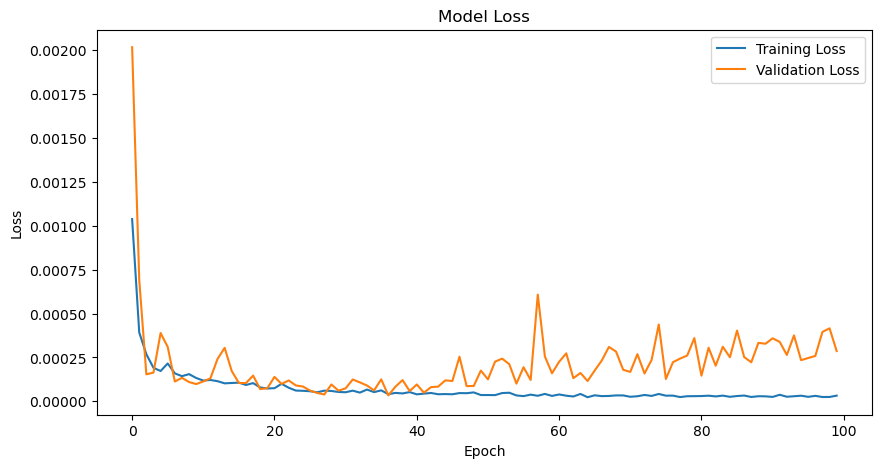

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
test_df = Ticker(ASSET).history(interval='1d', period='max')
test_df

open        high         low  \
symbol date                                                            
AAPL   1980-12-12                   0.128348    0.128906    0.128348   
       1980-12-15                   0.122210    0.122210    0.121652   
       1980-12-16                   0.113281    0.113281    0.112723   
       1980-12-17                   0.115513    0.116071    0.115513   
       1980-12-18                   0.118862    0.119420    0.118862   
...                                      ...         ...         ...   
       2023-10-12                 180.070007  182.339996  179.039993   
       2023-10-13                 181.419998  181.929993  178.139999   
       2023-10-16                 176.750000  179.080002  176.509995   
       2023-10-17                 176.649994  178.419998  174.800003   
       2023-10-18 16:00:01-04:00  175.580002  177.570007  175.110001   

                                       close     volume    adjclose  \
symbol date                                                           
AAPL   1980-12-12                   0.128348  469033600    0.099449   
       1980-12-15                   0.121652  175884800    0.094261   
       1980-12-16                   0.112723  105728000    0.087343   
       1980-12-17                   0.115513   86441600    0.089504   
       1980-12-18                   0.118862   73449600    0.092099   
...                                      ...        ...         ...   
       2023-10-12                 180.710007   56743100  180.710007   
       2023-10-13                 178.850006   51427100  178.850006   
       2023-10-16                 178.720001   52517000  178.720001   
       2023-10-17                 177.149994   57549400  177.149994   
       2023-10-18 16:00:01-04:00  175.839996   54587851  175.839996   

                                  dividends  splits  
symbol date                                          
AAPL   1980-12-12                       0.0     0.0  
       1980-12-15                       0.0     0.0  
       1980-12-16                       0.0     0.0  
       1980-12-17                       0.0     0.0  
       1980-12-18                       0.0     0.0  
...                                     ...     ...  
       2023-10-12                       0.0     0.0  
       2023-10-13                       0.0     0.0  
       2023-10-16                       0.0     0.0  
       2023-10-17                       0.0     0.0  
       2023-10-18 16:00:01-04:00        0.0     0.0  

[10803 rows x 8 columns]

In [16]:
test_df = test_df.reset_index(level='symbol')
test_df

,symbol,open,high,low,close,volume,adjclose,dividends,splits
date,,,,,,,,,
1980-12-12,AAPL,0.128348,0.128906,0.128348,0.128348,469033600,0.099449,0.0,0.0
1980-12-15,AAPL,0.122210,0.122210,0.121652,0.121652,175884800,0.094261,0.0,0.0
1980-12-16,AAPL,0.113281,0.113281,0.112723,0.112723,105728000,0.087343,0.0,0.0
1980-12-17,AAPL,0.115513,0.116071,0.115513,0.115513,86441600,0.089504,0.0,0.0
1980-12-18,AAPL,0.118862,0.119420,0.118862,0.118862,73449600,0.092099,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-10-12,AAPL,180.070007,182.339996,179.039993,180.710007,56743100,180.710007,0.0,0.0
2023-10-13,AAPL,181.419998,181.929993,178.139999,178.850006,51427100,178.850006,0.0,0.0
2023-10-16,AAPL,176.750000,179.080002,176.509995,178.720001,52517000,178.720001,0.0,0.0


In [17]:
test_df.index

Index([               1980-12-12,                1980-12-15,
                      1980-12-16,                1980-12-17,
                      1980-12-18,                1980-12-19,
                      1980-12-22,                1980-12-23,
                      1980-12-24,                1980-12-26,
       ...
                      2023-10-05,                2023-10-06,
                      2023-10-09,                2023-10-10,
                      2023-10-11,                2023-10-12,
                      2023-10-13,                2023-10-16,
                      2023-10-17, 2023-10-18 16:00:01-04:00],
      dtype='object', name='date', length=10803)

In [18]:
real_price = test_df['close'].values.reshape(-1, 1)

In [19]:
data_total = pd.concat((stck_data['close'], test_df['close']), axis=0)

In [20]:
inpts = data_total[len(data_total) - len(test_df) - 60:].values
inpts = inpts.reshape(-1, 1)
inpts = scaler.transform(inpts)
X_test = []
for i in range(60, len(inpts)):
    X_test.append(inpts[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [21]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2023-10-18 23:14:52.009538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 23:14:52.120060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 23:14:52.583218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 23:14:53.125352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 23:14:53.674688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 6s 10ms/step


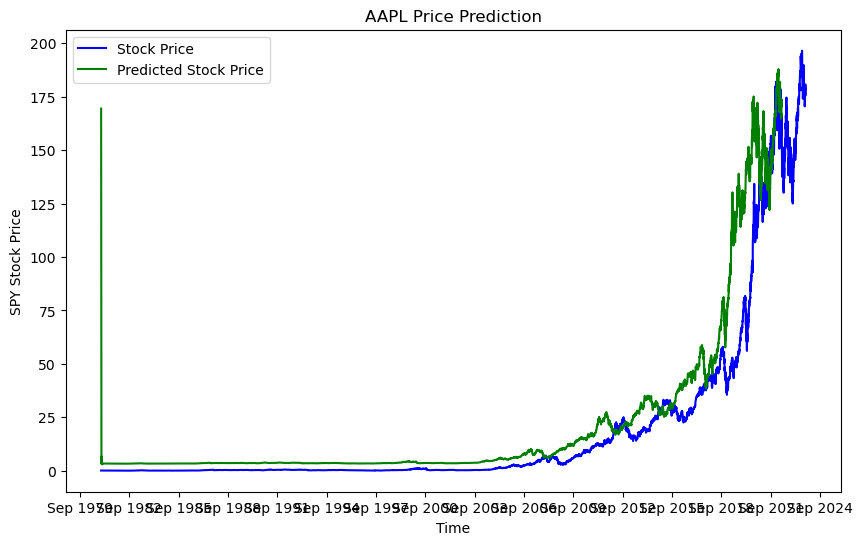

In [22]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='1980-12-12', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, real_price, color='blue', label='Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=36))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title(f"{ASSET} Price Prediction")
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()